In [21]:
# # Importing a number of different tools
# from sklearn.decomposition import PCA
# from matplotlib.backends.backend_pdf import PdfPages
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_context('poster')
# sns.set_style('whitegrid')
# import pandas
# from pystain import StainDataset

# # Start code
# subject_id = 13095
# ds = StainDataset(subject_id)

# conversion_matrix = np.array([[0, 0, ds.xy_resolution],
#                               [-ds.z_resolution, 0, 0],
#                               [0, -ds.xy_resolution, 0]])
# results = []

# # What are the subject IDs?
# subject_ids=[13095, 14037, 14051, 14069, 15033, 15035, 15055]

# # how many sub-sections along each axis?
# n_sectors_per_axis = 10

# # labels of sectors (this is ugly - sorry)
# axis_labels = {'pma': np.array([np.round(float(x)/n_sectors_per_axis,4) for x in np.arange(n_sectors_per_axis)]),
#                'vmd': np.array([np.round(float(x)/n_sectors_per_axis,4) for x in np.arange(n_sectors_per_axis)]),
#                'mml': np.array([np.round(float(x)/n_sectors_per_axis,4) for x in np.arange(n_sectors_per_axis)])}

# # # Define mid-point along each axis as origin (0,0,0)
# # for axis, sectors in axis_labels.items():
# #     axis_labels[axis] = sectors - sectors.mean()
# #     axis_labels[axis] = [axis + '_' + str(x) for x in axis_labels[axis]]


# for fwhm in [None]:
#     for subject_id in subject_ids[:]:
#         ds = StainDataset(subject_id, fwhm=fwhm)

#         # Get coordinates of mask and bring them to mm
#         x, y, z = np.where(ds.thresholded_mask)
#         coords = np.column_stack((x, y, z))
#         coords_mm = conversion_matrix.dot(coords.T).T
#         coords_mm -= coords_mm.mean(0)

#         # Fit two components and make sure first axis walks dorsal
#         #   and second component lateral
#         pca = PCA()
#         pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

#         components = pca.components_
#         print(components)

#         if components[0, 1] < 0:
#             components[0] = -components[0]

#         if components[1, 0] < 0:
#             components[1] = -components[1]

#         print(components)

#         # principal components
#         coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
#         coords_dataframe['slice'] = x

#         coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
#         coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

#         coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

#         # cut along axes
#         coords_dataframe['slice_sector'] = x
#         coords_dataframe['pc1_sector'] = coords_dataframe.groupby('slice_sector')['pc1'].apply(lambda d: pandas.qcut(d, n_sectors_per_axis))
#         coords_dataframe['pc1_mm'] = coords_dataframe['pc1_sector'].apply(lambda x: x.mid)
#         coords_dataframe['pc2_sector'] = coords_dataframe.groupby(['slice_sector', 'pc1_mm'])['pc2'].apply(lambda d: pandas.qcut(d, n_sectors_per_axis))

#         if fwhm is None:
#             df = pandas.concat((ds.dataframe, coords_dataframe), 1)
#         else:
#             df = pandas.concat((ds.smoothed_dataframe, coords_dataframe), 1)
#         df['n_voxels'] = 1
#         tmp = df.pivot_table(index=['pc1_sector', 'pc2_sector', 'slice_sector'], values=ds.stains + ['n_voxels'], aggfunc='sum').copy()
#         tmp['subject_id'] = subject_id

#         results.append(tmp.copy())

#     df = pandas.concat(results).reset_index()
#     df = df.melt(id_vars=['subject_id', 'slice_sector', 'pc1_sector', 'pc2_sector', 'n_voxels'], var_name='stain')

#     # get location of voxels in slice/pc1/pc2-space in mm
#     df['slice_mm'] = (df['slice_sector']-1) * ds.z_resolution
#     df['pc1_mm'] = df['pc1_sector'].apply(lambda x: x.mid)
#     df['pc2_mm'] = df['pc2_sector'].apply(lambda x: x.mid)

#     # get rate
#     df['rate'] = df['value']/pandas.to_numeric(df['n_voxels'])

#     # get location of voxels in slice/pc1/pc2-space in voxel number along that dimension (0, 1, ..., n_voxels)
#     def return_unique_id(x):
#         dict_ = dict(zip(np.unique(x.values), np.arange(np.unique(x.values).shape[0])))
#         return(dict_)
#     df = pandas.merge(df, df.groupby(['subject_id', 'slice_sector']).pc1_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'pc1_mm': 'pc1_sector_number', 'level_2': 'pc1_mm'}), how='left')
#     df = pandas.merge(df, df.groupby(['subject_id', 'slice_sector', 'pc1_sector_number']).pc2_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'pc2_mm': 'pc2_sector_number', 'level_3': 'pc2_mm'}), how='left')

#     # name voxels for groupby-options used in plotting
#     df['slice_sector_name'] = 'pma_' + np.round(df['slice_mm'],3).astype(str).values
#     df['pc1_sector_name'] = 'vmd_' + df['pc1_mm'].round(3).astype(str).values
#     df['pc2_sector_name'] = 'mml_' + df['pc2_mm'].round(3).astype(str).values

#     # scale location of voxels to [0, 1]
#     def to_percentage(x):
#         return (x-x.min())/(x-x.min()).max()
#     df['pc1_mm_perc'] = df.groupby('subject_id').pc1_mm.apply(lambda x: to_percentage(x)) #(df['pc1_mm']-df['pc1_mm'].min())/(df['pc1_mm']-df['pc1_mm'].min()).max()
#     df['pc2_mm_perc'] = df.groupby('subject_id').pc2_mm.apply(lambda x: to_percentage(x))
#     df['slice_mm_perc'] = df.groupby('subject_id').slice_mm.apply(lambda x: to_percentage(x))
#     df['slice_sector_perc'] = df['slice_mm_perc']

#     # save
#     if fwhm is None:
#         fn = './data_fwhm-0.pkl'
#     else:
#         fn = './data_fwhm-{}.pkl'.format(fwhm)
#     df.to_pickle(fn)

In [1]:
## No groupbys

In [22]:
# # Importing a number of different tools
# from sklearn.decomposition import PCA
# from matplotlib.backends.backend_pdf import PdfPages
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_context('poster')
# sns.set_style('whitegrid')
# import pandas
# from pystain import StainDataset

# # Start code
# subject_id = 13095
# ds = StainDataset(subject_id)

# conversion_matrix = np.array([[0, 0, ds.xy_resolution],
#                               [-ds.z_resolution, 0, 0],
#                               [0, -ds.xy_resolution, 0]])
# results = []

# # What are the subject IDs?
# subject_ids=[13095, 14037, 14051, 14069, 15033, 15035, 15055]

# # how many sub-sections along each axis? 2, 3, 4, ...
# n_sectors_per_axis = 20

# # labels of sectors (this is ugly - sorry)
# axis_labels = {'pma': np.array([np.round(float(x)/n_sectors_per_axis,4) for x in np.arange(n_sectors_per_axis)]),
#                'vmd': np.array([np.round(float(x)/n_sectors_per_axis,4) for x in np.arange(n_sectors_per_axis)]),
#                'mml': np.array([np.round(float(x)/n_sectors_per_axis,4) for x in np.arange(n_sectors_per_axis)])}

# # # Define mid-point along each axis as origin (0,0,0)
# # for axis, sectors in axis_labels.items():
# #     axis_labels[axis] = sectors - sectors.mean()
# #     axis_labels[axis] = [axis + '_' + str(x) for x in axis_labels[axis]]


# for fwhm in [0.3, 0.15, None]:
#     for subject_id in subject_ids[:]:
#         ds = StainDataset(subject_id, fwhm=fwhm)

#         # Get coordinates of mask and bring them to mm
#         x, y, z = np.where(ds.thresholded_mask)
#         coords = np.column_stack((x, y, z))
#         coords_mm = conversion_matrix.dot(coords.T).T
#         coords_mm -= coords_mm.mean(0)

#         # Fit two components and make sure first axis walks dorsal
#         #   and second component lateral
#         pca = PCA()
#         pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

#         components = pca.components_
#         print(components)

#         if components[0, 1] < 0:
#             components[0] = -components[0]

#         if components[1, 0] < 0:
#             components[1] = -components[1]

#         print(components)

#         # principal components
#         coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
#         coords_dataframe['slice'] = x

#         coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
#         coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

#         coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

#         # cut along axes
#         coords_dataframe['slice_sector'] = x
#         coords_dataframe['pc1_sector'] = coords_dataframe['pc1'].apply(lambda d: pandas.qcut(d, n_sectors_per_axis))
#         coords_dataframe['pc2_sector'] = coords_dataframe['pc2'].apply(lambda d: pandas.qcut(d, n_sectors_per_axis))

#         if fwhm is None:
#             df = pandas.concat((ds.dataframe, coords_dataframe), 1)
#         else:
#             df = pandas.concat((ds.smoothed_dataframe, coords_dataframe), 1)
#         df['n_voxels'] = 1
#         tmp = df.pivot_table(index=['pc1_sector', 'pc2_sector', 'slice_sector'], values=ds.stains + ['n_voxels'], aggfunc='sum').copy()
#         tmp['subject_id'] = subject_id

#         results.append(tmp.copy())

#     df = pandas.concat(results).reset_index()
#     df = df.melt(id_vars=['subject_id', 'slice_sector', 'pc1_sector', 'pc2_sector', 'n_voxels'], var_name='stain')

#     # get location of voxels in slice/pc1/pc2-space in mm
#     df['slice_mm'] = (df['slice_sector']-1) * ds.z_resolution
#     df['pc1_mm'] = df['pc1_sector'].apply(lambda x: x.mid)
#     df['pc2_mm'] = df['pc2_sector'].apply(lambda x: x.mid)

#     # get rate
#     df['rate'] = df['value']/pandas.to_numeric(df['n_voxels'])

#     # get location of voxels in slice/pc1/pc2-space in voxel number along that dimension (0, 1, ..., n_voxels)
#     def return_unique_id(x):
#         dict_ = dict(zip(np.unique(x.values), np.arange(np.unique(x.values).shape[0])))
#         return(dict_)
#     df = pandas.merge(df, df.groupby(['subject_id', 'slice_sector']).pc1_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'pc1_mm': 'pc1_sector_number', 'level_2': 'pc1_mm'}), how='left')
#     df = pandas.merge(df, df.groupby(['subject_id', 'slice_sector', 'pc1_sector_number']).pc2_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'pc2_mm': 'pc2_sector_number', 'level_3': 'pc2_mm'}), how='left')

#     # name voxels for groupby-options used in plotting
#     df['slice_sector_name'] = 'pma_' + np.round(df['slice_mm'],3).astype(str).values
#     df['pc1_sector_name'] = 'vmd_' + df['pc1_mm'].round(3).astype(str).values
#     df['pc2_sector_name'] = 'mml_' + df['pc2_mm'].round(3).astype(str).values

#     # scale location of voxels to [0, 1]
#     def to_percentage(x):
#         return (x-x.min())/(x-x.min()).max()
#     df['pc1_mm_perc'] = df.groupby('subject_id').pc1_mm.apply(lambda x: to_percentage(x)) #(df['pc1_mm']-df['pc1_mm'].min())/(df['pc1_mm']-df['pc1_mm'].min()).max()
#     df['pc2_mm_perc'] = df.groupby('subject_id').pc2_mm.apply(lambda x: to_percentage(x))
#     df['slice_mm_perc'] = df.groupby('subject_id').slice_mm.apply(lambda x: to_percentage(x))
#     df['slice_sector_perc'] = df['slice_mm_perc']

#     # save
#     if fwhm is None:
#         fn = './data_nogrpby_fwhm-0.pkl'
#     else:
#         fn = './data_nogrpby_fwhm-{}.pkl'.format(fwhm)
#     df.to_pickle(fn)

### 10 sectors per axis

A total of equivolume 1000 voxels per STN

In [38]:
# Importing a number of different tools
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import pandas
from pystain import StainDataset

# Start code
subject_id = 13095
ds = StainDataset(subject_id)

conversion_matrix = np.array([[0, 0, ds.xy_resolution],
                              [-ds.z_resolution, 0, 0],
                              [0, -ds.xy_resolution, 0]])
results = []

# What are the subject IDs?
subject_ids=[13095, 14037, 14051, 14069, 15033, 15035, 15055]

# how many sub-sections along each axis?
n_sectors_per_axis = 10

for fwhm in [.3, None]:
    for subject_id in subject_ids[:]:
        ds = StainDataset(subject_id, fwhm=fwhm)

        # Get coordinates of mask and bring them to mm
        x, y, z = np.where(ds.thresholded_mask)
        coords = np.column_stack((x, y, z))
        coords_mm = conversion_matrix.dot(coords.T).T
        coords_mm -= coords_mm.mean(0)

        # Fit two components and make sure first axis walks dorsal
        #   and second component lateral
        pca = PCA()
        pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

        components = pca.components_
        print(components)

        if components[0, 1] < 0:
            components[0] = -components[0]

        if components[1, 0] < 0:
            components[1] = -components[1]

        print(components)

        # principal components
        coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
        coords_dataframe['slice'] = x

        coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
        coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

        coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

        # cut along axes
        coords_dataframe['slice_sector'] = pandas.qcut((x-1)*ds.z_resolution, n_sectors_per_axis)
        coords_dataframe['slice_mm'] = coords_dataframe['slice_sector'].apply(lambda x: x.mid)
        coords_dataframe['pc1_sector'] = coords_dataframe.groupby('slice_mm')['pc1'].apply(lambda d: pandas.qcut(d, n_sectors_per_axis))
        coords_dataframe['pc1_mm'] = coords_dataframe['pc1_sector'].apply(lambda x: x.mid)
        coords_dataframe['pc2_sector'] = coords_dataframe.groupby(['slice_mm', 'pc1_mm'])['pc2'].apply(lambda d: pandas.qcut(d, n_sectors_per_axis))
        coords_dataframe['pc2_mm'] = coords_dataframe['pc2_sector'].apply(lambda x: x.mid)

        if fwhm is None:
            df = pandas.concat((ds.dataframe, coords_dataframe), 1)
        else:
            df = pandas.concat((ds.smoothed_dataframe, coords_dataframe), 1)
        df['n_voxels'] = 1
        tmp = df.pivot_table(index=['slice_mm', 'pc1_mm', 'pc2_mm'], values=ds.stains + ['n_voxels'], aggfunc='sum').copy()
        tmp['subject_id'] = subject_id

        results.append(tmp.copy())

    df = pandas.concat([x.reset_index() for x in results])
    df = df.melt(id_vars=['subject_id', 'slice_mm', 'pc1_mm', 'pc2_mm', 'n_voxels'], var_name='stain')

    # get rate
    df['rate'] = df['value']/pandas.to_numeric(df['n_voxels'])

    # get location of voxels in slice/pc1/pc2-space in voxel number along that dimension (0, 1, ..., n_voxels)
    def return_unique_id(x):
        dict_ = dict(zip(np.unique(x.values), np.arange(np.unique(x.values).shape[0])))
        return(dict_)
    
#     df = pandas.merge(df, df.groupby(['subject_id']).slice_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'slice_mm': 'slice_sector_number'}), how='left')
    df = pandas.merge(df, df.groupby(['subject_id', 'slice_mm']).pc1_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'pc1_mm': 'pc1_sector_number', 'level_2': 'pc1_mm'}), how='left')
    df = pandas.merge(df, df.groupby(['subject_id', 'slice_mm', 'pc1_sector_number']).pc2_mm.apply(lambda x: return_unique_id(x)).reset_index().rename(columns={'pc2_mm': 'pc2_sector_number', 'level_3': 'pc2_mm'}), how='left')

    # name voxels for groupby-options used in plotting
    df['slice_sector_name'] = 'pma_' + np.round(df['slice_mm'],3).astype(str).values
    df['pc1_sector_name'] = 'vmd_' + df['pc1_mm'].round(3).astype(str).values
    df['pc2_sector_name'] = 'mml_' + df['pc2_mm'].round(3).astype(str).values

    def to_norm(x):
        return (x-x.mean())/x.std()

    # scale to norm
    df['pc1_mm_norm'] = df.groupby(['subject_id', 'stain']).pc1_mm.apply(lambda x: to_norm(x))
    df['pc2_mm_norm'] = df.groupby(['subject_id', 'stain']).pc2_mm.apply(lambda x: to_norm(x))
    df['slice_mm_norm'] = df.groupby(['subject_id', 'stain']).slice_mm.apply(lambda x: to_norm(x))

    # save
    if fwhm is None:
        fn = './data_fwhm-0.pkl'
    else:
        fn = './data_fwhm-{}.pkl'.format(fwhm)
    df.to_pickle(fn)

/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
[[-0.98094749 -0.19427308]
 [-0.19427308  0.98094749]]
[[ 0.98094749  0.19427308]
 [ 0.19427308 -0.98094749]]
/home/stevenm/data/post_mortem/new_data_format/14037/images.hdf5
[[-0.95611755 -0.29298334]
 [ 0.29298334 -0.95611755]]
[[ 0.95611755  0.29298334]
 [ 0.29298334 -0.95611755]]
/home/stevenm/data/post_mortem/new_data_format/14051/images.hdf5
[[-0.78933812 -0.61395874]
 [ 0.61395874 -0.78933812]]
[[ 0.78933812  0.61395874]
 [ 0.61395874 -0.78933812]]
/home/stevenm/data/post_mortem/new_data_format/14069/images.hdf5
[[-0.70764237 -0.70657079]
 [ 0.70657079 -0.70764237]]
[[ 0.70764237  0.70657079]
 [ 0.70657079 -0.70764237]]
/home/stevenm/data/post_mortem/new_data_format/15033/images.hdf5
[[-0.66358108 -0.74810437]
 [ 0.74810437 -0.66358108]]
[[ 0.66358108  0.74810437]
 [ 0.74810437 -0.66358108]]
/home/stevenm/data/post_mortem/new_data_format/15035/images.

/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/pystain-0.1-py3.5.egg/pystain/utils.py:20: RuntimeWarning: invalid value encountered in true_divide
  new_data=VV/WW


Smoothing FER
Smoothing GABRA3
Smoothing GAD6567
Smoothing MBP
Smoothing PARV
Smoothing SERT
Smoothing SMI32
Smoothing SYN
Smoothing TH
Smoothing TRANSF
Smoothing VGLUT1
calculating vmin
calculating vmax
[[-0.61137631 -0.79134   ]
 [-0.79134     0.61137631]]
[[ 0.61137631  0.79134   ]
 [ 0.79134    -0.61137631]]
/home/stevenm/data/post_mortem/new_data_format/15055/images.hdf5
[[-0.77494798 -0.63202503]
 [-0.63202503  0.77494798]]
[[ 0.77494798  0.63202503]
 [ 0.63202503 -0.77494798]]
/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
[[-0.98094749 -0.19427308]
 [-0.19427308  0.98094749]]
[[ 0.98094749  0.19427308]
 [ 0.19427308 -0.98094749]]
/home/stevenm/data/post_mortem/new_data_format/14037/images.hdf5
[[-0.95611755 -0.29298334]
 [ 0.29298334 -0.95611755]]
[[ 0.95611755  0.29298334]
 [ 0.29298334 -0.95611755]]
/home/stevenm/data/post_mortem/new_data_format/14051/images.hdf5
[[-0.78933812 -0.61395874]
 [ 0.61395874 -0.78933812]]
[[ 0.78933812  0.61395874]
 [ 0.61395874 

In [42]:
df_orig = pandas.read_pickle('./data_fhwm-0_orig.pkl')

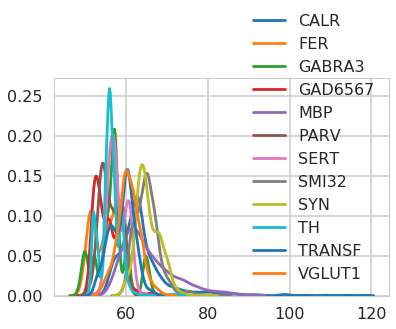

In [43]:
import seaborn as sns
for stain in df['stain'].unique():
    sns.kdeplot(df_orig.loc[(df_orig.stain==stain) & (df_orig.subject_id==15035), 'rate'], label=stain)

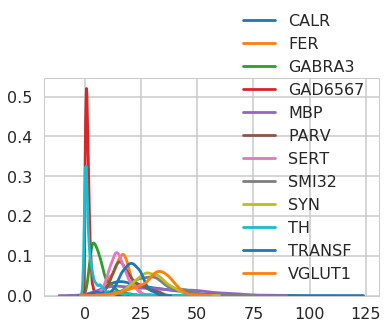

In [50]:
import seaborn as sns
for stain in df['stain'].unique():
    sns.kdeplot(df.loc[(df.stain==stain) & (df.subject_id==15035), 'rate'], label=stain)

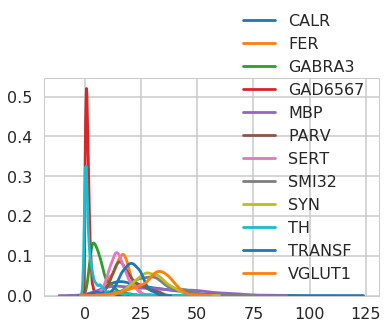

In [51]:
import seaborn as sns
for stain in df['stain'].unique():
    sns.kdeplot(df.loc[(df.stain==stain) & (df.subject_id==15035), 'rate'], label=stain)

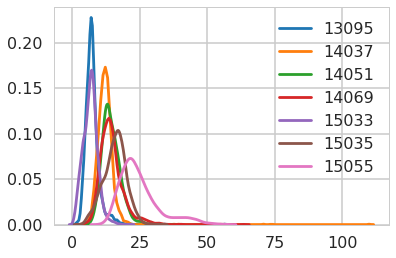

In [55]:
for subject in df['subject_id'].unique():
    sns.kdeplot(df.loc[(df.stain=='FER') & (df.subject_id==subject), 'rate'], label=subject)

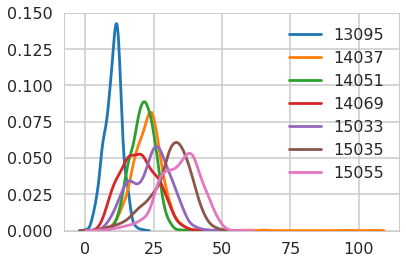

In [56]:
for subject in df['subject_id'].unique():
    sns.kdeplot(df.loc[(df.stain=='VGLUT1') & (df.subject_id==subject), 'rate'], label=subject)

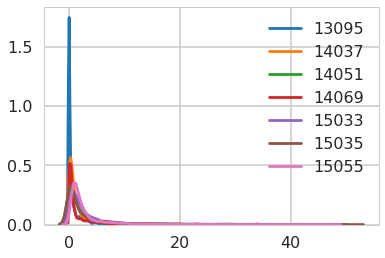

In [57]:
for subject in df['subject_id'].unique():
    sns.kdeplot(df.loc[(df.stain=='TH') & (df.subject_id==subject), 'rate'], label=subject)